# 1- Introduction

In this notebook, we will demonstrate how to use the awkward table and how to build selector efficiently using lambda's in python

In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc

First we need to identify the awkward tables as vectors

In [2]:
vector.register_awkward() 

We then collect the data (either MC or real data)

In [3]:
DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [5]:
SAMPLE_RUNS=[291694,291399]

Let's now open the root file and print the content

In [6]:
file = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))
events = file["eventsTree"]
events.show()

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'mc'} .root
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | st

In [7]:
genfile = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))
genevents = file["genTree"]
genevents.show()

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'mc'} .root
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
xVtxMC               | double                   | AsDtype('>f8')
yVtxMC               | double                   | AsDtype('>f8')
zVtxMC               | double                   | AsDtype('>f8')
nMuonsGen            | int32_t                  | AsDtype('>i4')
Muon_GenE            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_GenPx           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_GenPy           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_GenPz           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_GenLabel        | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
Muon_GenMotherPDG... | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...


We will just print here the number of entries (events) in the file for the record

In [8]:
events.num_entries

40000

In [9]:
genevents.num_entries

40000

# 2- 4-momentum vector with awkward and selectors

It is possible to build an awkward table as a 4-momentum vector. To do that, you need to use the "zip" method whith px, py, pz and E as its 4 first members. You also need to call this table with the following specific name "Momentum4D"

This allow you in the following to get the kinematics of your tracks quite easily by calling:
- .p, .px, .py, .pz, .pt, ... for the momentum
- .eta for the pseudo-rapidity
- ...

Indeed, you can also add more information to the awkward table after defining the first 4 members of the table (as you can see below)

We are here implementing a "getTracks" function that will be use in the following to select tracks. See here:

In [10]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "DCAx":events["Muon_xDCA"],
                       "DCAy":events["Muon_yDCA"],
                       "DCAz":events["Muon_zDCA"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [11]:
def getgenTracks(genevents):
    return ak.zip({"px":genevents["Muon_GenPx"],
                       "py":genevents["Muon_GenPy"],
                       "pz":genevents["Muon_GenPz"],
                       "E":genevents["Muon_GenE"]},
                    with_name='Momentum4D')

Now we will design a function to run over the data with uproot. 
In the iterate, we define all the variable we want to access for each events

We first select good events and track using lambdas in python. What is a good event or a good track will be define later when we call the function "scan"

In [12]:
def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hpDCA:hist.Hist, hsigmapDCA:hist.Hist, hfraction:hist.Hist, hpt:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_xDCA","Muon_yDCA","Muon_zDCA","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(events)
        goodTracks=tracks[trackSelector(tracks)]

        #computing pDCA
        DCA=np.sqrt(goodTracks.DCAx**2 + goodTracks.DCAy**2 + goodTracks.DCAz**2)
        p0=ak.where(goodTracks.thetaAbs < 3 , goodTracks.p - 3.0, goodTracks.p - 2.4)
        pDCA=p0*DCA
        #print("pDCA minimum value is : ", ak.min(pDCA) , " and pDCA maximum value is : ", ak.max(pDCA))

        ##computing pDCA resolution to define the cut 
        #momentum resolution for pDCA 
        N=1 #choice of resolution should be a number between 1 and 10
        sigmaAbs=ak.where(goodTracks.thetaAbs < 3, 80.0, 54.0) #factor used due to the crossed materials 
        pRes= 0.0004 * goodTracks.p
        sigmap= sigmaAbs/ (1 - ((N*pRes)/(1 + N*pRes)))

        #angular resolution for pDCA
        thetaRes= 0.0005 * goodTracks.p
        sigmatheta= 535 * thetaRes

        #computing total resolution for pDCA
        sigmapDCA=np.sqrt(sigmap**2 + sigmatheta**2)

        ##function to choose the N value
        fraction=pDCA/sigmapDCA

        hpt.fill(ak.flatten(goodTracks.pt))
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi))
        hpDCA.fill(ak.flatten(pDCA))
        hsigmapDCA.fill(ak.flatten(sigmapDCA))
        hfraction.fill(ak.flatten(fraction))
        
        if verbose:
            print(batch[1])
        gc.collect()
       


In [13]:
def scangen(dataDescription, 
              hptgen:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["Muon_GenPx","Muon_GenPy","Muon_GenPz","Muon_GenE"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getgenTracks(events)
        goodTracks=tracks[trackSelector(tracks)]
        
        hptgen.fill(ak.flatten(goodTracks.pt))
        
        if verbose:
            print(batch[1])
        gc.collect()
        

We define now some histograms that we want to plot and run over the data. We do it twice for illustration purposes:
- first, we don't give any definition for the eventselector and track selector. This is equivalent to say that all events and all tracks are good
- second, we implement some definition for the lambda function to have some selection criteria on our tracks


In [22]:
%%time
## SINGLE MUON TRACK PLOTS
#No cuts
vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))
#Event selection
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))

#pDCA
vhpDCAEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=2500,name='pDCA'))
vhpDCARaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=2500,name='pDCA'))

#sigmapDCA
vhsigmapDCAEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=300,name=r'$\sigma_{pDCA}$'))
vhsigmapDCARaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=100,name=r'$\sigma_{pDCA}$'))

#fraction
vhfractionEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=10,name=r'pDCA/$\sigma_{pDCA}$'))
vhfractionRaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=10,name=r'pDCA/$\sigma_{pDCA}$'))


#pt selection
vhptRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=15,name='$p_T$'))
vhptEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=15,name='$p_T$'))
vhptgen = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=15,name='$p_T$'))

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hpDCA=vhpDCARaw, hsigmapDCA=vhsigmapDCARaw, hfraction=vhfractionRaw, hpt=vhptRaw)

scangen(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:genTree",
        hptgen=vhptgen)

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel, hpDCA=vhpDCAEvSel, hsigmapDCA=vhsigmapDCAEvSel, hfraction=vhfractionEvSel, hpt=vhptEvSel,
          eventSelector=lambda x: (x["isCMUL"]==True),
          trackSelector=lambda x: (x.pt>0.5) & (x.eta<-2.5) & (x.eta>-4.0))


CPU times: user 972 ms, sys: 22.1 ms, total: 995 ms
Wall time: 1.01 s


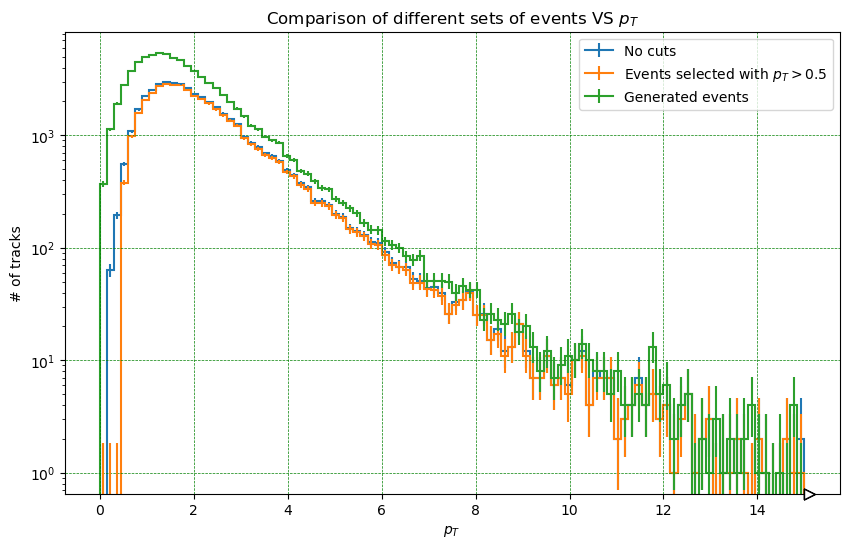

In [23]:
plt.figure(figsize=(10, 6))
vhptRaw.plot(label="No cuts")
vhptEvSel.plot(label= r"Events selected with $p_T>0.5$")
vhptgen.plot(label="Generated events")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Comparison of different sets of events VS $p_T$');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();
#plt.savefig("pt_all_tracks_run291694.png")

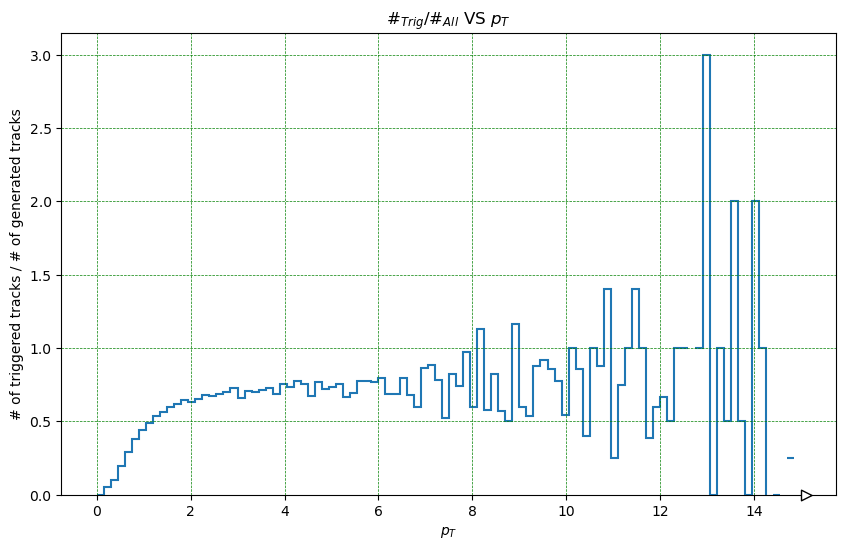

In [24]:
plt.figure(figsize=(10, 6))
(vhptRaw/vhptgen).plot()
plt.ylabel("# of triggered tracks / # of generated tracks")
plt.title(r'#$_{Trig}$/#$_{All}$ VS $p_T$');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
#plt.savefig("pt_cut_run291694.png")

### p*DCA distribution
In order to compute the p*DCA, the muon momentum has to be evaluated at the entrance of the tracking system, after multiple Coulomb scattering in the absorber. Since the reconstructed muon momenta are provided at the interaction vertex and corrected for absorber effects, we recompute the momentum at the first tracking station by substracting the average energy loss correction. This correction depends on the muon polar angle, reflecting the different material thicknesses crossed inside the absorber. 

Therefore, the momentum is computed as 

p = pcorr - 3.0 for theta_Abs < 3

and

p = pcorr - 2.4 for theta_Abs >= 3


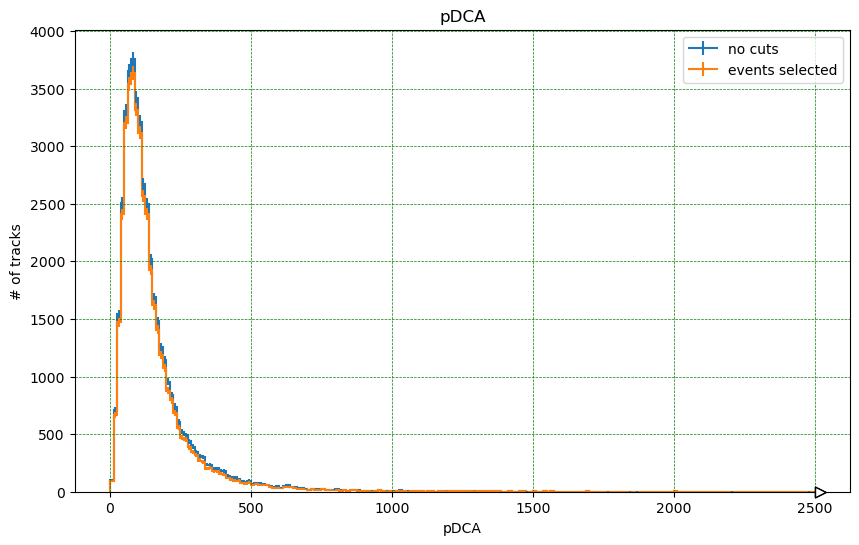

In [25]:
plt.figure(figsize=(10, 6))
vhpDCARaw.plot(label="no cuts")
vhpDCAEvSel.plot(label="events selected")
#plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('pDCA');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();
#plt.savefig("pDCA_run291694.png")

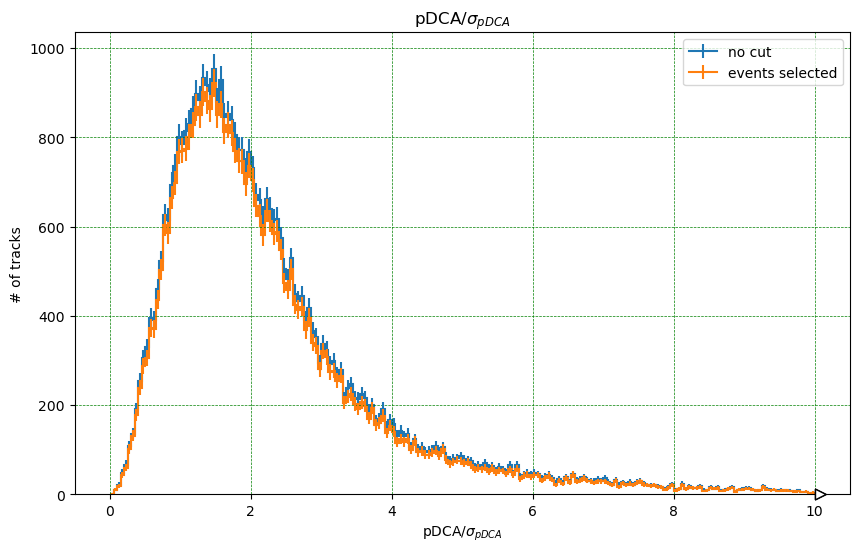

In [27]:
plt.figure(figsize=(10, 6))
vhfractionRaw.plot(label="no cut")
vhfractionEvSel.plot(label="events selected")
#plt.yscale("log")
plt.ylabel("# of tracks")
plt.title(r'pDCA/$\sigma_{pDCA}$');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();
#plt.savefig("pDCA_sigmapDCA_run291694.png")

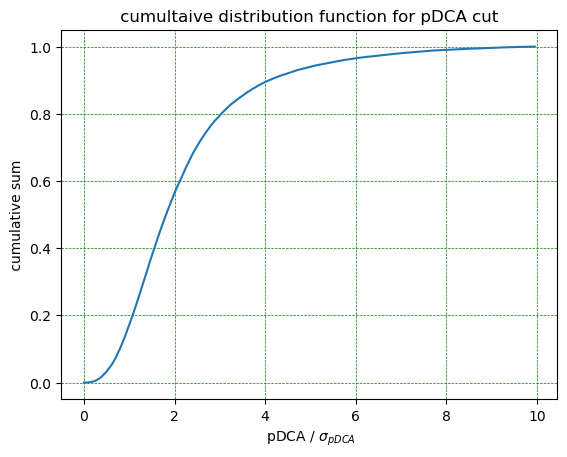

In [28]:
N_tracks=vhfractionEvSel.values()
#print(N_tracks)

x_ax=vhfractionEvSel.axes[0].edges
#print(x_ax)

dx=x_ax[1] -x_ax[0]
#print(dx)

norm_N_tracks=N_tracks/np.sum(N_tracks*dx)

Integral=np.cumsum(norm_N_tracks)*dx

plt.plot(x_ax[:-1],Integral)
plt.xlabel(r" pDCA / $\sigma_{pDCA}$ ")
plt.ylabel(" cumulative sum ")
plt.title(" cumultaive distribution function for pDCA cut ")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
#plt.savefig("cumsum_pDCA_cut.png")

### We can now plot the results! See from the plots that our selection removed some entries in all histograms

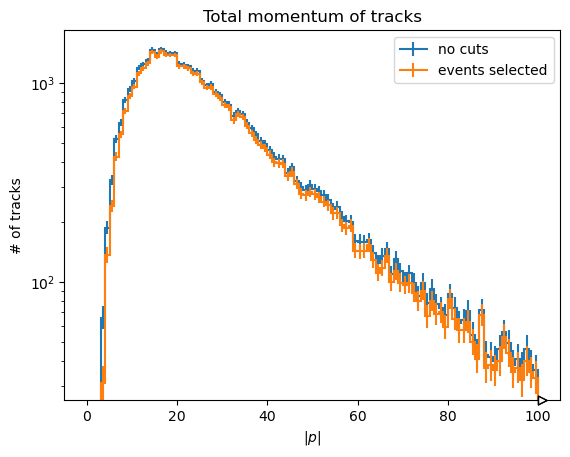

In [20]:
vhMagRaw.plot(label="no cuts")
vhMagEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Total momentum of tracks');
plt.legend();

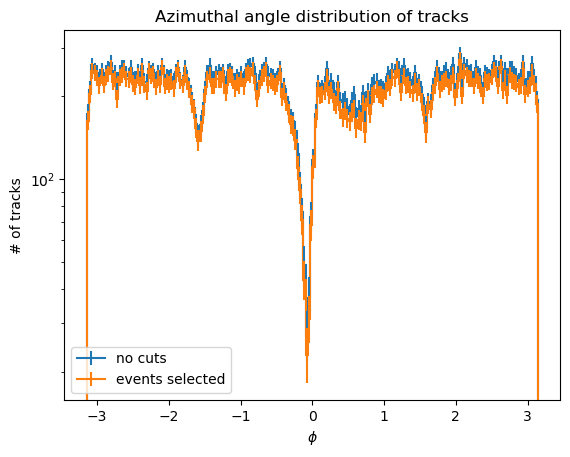

In [21]:
vhPhiRaw.plot(label="no cuts")
vhPhiEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Azimuthal angle distribution of tracks');
plt.legend();